In [410]:
import SimFunctions
import SimClasses
import SimRNG
import SimRNG_Modified
import simpy
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import probplot, kstest
import pickle
warnings.filterwarnings("ignore")
# fix random number seed
np.random.seed(1)

ZSimRNG = SimRNG_Modified.InitializeRNSeed()


# Data Loading & Preprocessing 

In [411]:
#subset_df = pd.read_csv("10_station_subset.csv")
subset_df = pd.read_csv("top20_station_subset.csv")


In [412]:
subset_df

,Unnamed: 0,Trip Id,Trip_Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,NumOfTrips,Start Time (per 30min),End Time (per 30min),Start Time (minutes),End Time (minutes)
0,0,17515475,29.566667,7203,2022-08-01 00:02:00,Bathurst St/Queens Quay(Billy Bishop Airport),7261.0,2022-08-01 00:32:00,Queens Quay E / Lower Sherbourne St,6908,Casual Member,72,0.0,1.0,2,32
1,18537,17961013,13.583333,7006,2022-08-18 00:14:00,Bay St / College St (East Side),7217.0,2022-08-18 00:28:00,Soho St / Queen St W,5958,Casual Member,49,0.0,0.0,14,28
2,18536,17961003,14.216667,7006,2022-08-18 00:13:00,Bay St / College St (East Side),7217.0,2022-08-18 00:27:00,Soho St / Queen St W,2635,Annual Member,49,0.0,0.0,13,27
3,11661,18045153,16.400000,7298,2022-08-21 00:24:00,Bathurst St / Adelaide St W,7076.0,2022-08-21 00:41:00,York St / Queens Quay W,641,Annual Member,14,0.0,1.0,24,41
4,11660,18013115,17.833333,7298,2022-08-20 00:10:00,Bathurst St / Adelaide St W,7076.0,2022-08-20 00:28:00,York St / Queens Quay W,3264,Casual Member,14,0.0,0.0,10,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19091,15108,17960848,15.116667,7043,2022-08-17 23:58:00,Queens Quay W / Lower Simcoe St,7261.0,2022-08-18 00:13:00,Queens Quay E / Lower Sherbourne St,1666,Casual Member,61,47.0,0.0,1438,13
19092,455,17853247,21.000000,7043,2022-08-13 23:53:00,Queens Quay W / Lower Simcoe St,7203.0,2022-08-14 00:14:00,Bathurst St/Queens Quay(Billy Bishop Airport),4985,Casual Member,103,47.0,0.0,1433,14
19093,456,17853266,19.816667,7043,2022-08-13 23:54:00,Queens Quay W / Lower Simcoe St,7203.0,2022-08-14 00:14:00,Bathurst St/Queens Quay(Billy Bishop Airport),3647,Casual Member,103,47.0,0.0,1434,14
19094,19009,18044327,2.500000,7168,2022-08-20 23:33:00,Queens Quay / Yonge St,7016.0,2022-08-20 23:35:00,Bay St / Queens Quay W (Ferry Terminal),2448,Annual Member,82,47.0,47.0,1413,1415


## Arrival Rates

In [413]:
# Convert the start time and end time to minutes
subset_df['Start Time'] = pd.to_datetime(subset_df['Start Time'])
subset_df['End Time'] = pd.to_datetime(subset_df['End Time'])
subset_df['Start Time (per 30min)'] = (subset_df['Start Time'].dt.hour * 60 + (subset_df['Start Time'].dt.minute // 30) * 30 ) / 30
subset_df['End Time (per 30min)'] = (subset_df['End Time'].dt.hour * 60 + (subset_df['End Time'].dt.minute // 30) * 30 ) / 30

# Group the data by station and 30-minute interval, and count the number of trips that started in each group
Start_Station_HalfHour_Arrivals = subset_df.groupby([subset_df['Start Station Name'],subset_df['Start Station Id'], subset_df['Start Time (per 30min)']]).size().reset_index(name='ArrivalRate (per 30min)')
#Start_Station_HalfHour_Arrivals = subset_df.groupby([subset_df['Start Station Name'], subset_df['Start Station Id'], subset_df['End Station Name'], subset_df['End Station Id'], subset_df['Start Time (per 30min)']]).size().reset_index(name='ArrivalRate (per 30min)')

# Calculate the arrival rate at each station and 30-minute interval (trips per hour)
Start_Station_HalfHour_Arrivals['ArrivalRate (per min)'] = Start_Station_HalfHour_Arrivals['ArrivalRate (per 30min)'] / 30

# Display the result
arrival_df = Start_Station_HalfHour_Arrivals.sort_values(by="Start Time (per 30min)")
arrival_df


,Start Station Name,Start Station Id,Start Time (per 30min),ArrivalRate (per 30min),ArrivalRate (per min)
0,Bathurst St / Adelaide St W,7298,0.0,9,0.300000
787,York St / Queens Quay W,7076,0.0,12,0.400000
92,Bay St / College St (East Side),7006,0.0,8,0.266667
744,Union Station,7033,0.0,2,0.066667
134,Bay St / Queens Quay W (Ferry Terminal),7016,0.0,9,0.300000
...,...,...,...,...,...
133,Bay St / College St (East Side),7006,47.0,4,0.133333
743,Soho St / Queen St W,7217,47.0,3,0.100000
91,Bathurst St/Queens Quay(Billy Bishop Airport),7203,47.0,27,0.900000
609,Queens Quay / Yonge St,7168,47.0,13,0.433333


In [414]:
desc = arrival_df.describe()[1:2].values
mean_arrival_30 = desc[0][2]
mean_arrival_min = desc[0][3]

customer_per_30min = mean_arrival_30
customer_per_min = mean_arrival_min
print(f"Customers Per 30 min = {customer_per_30min}")
print(f"Customers Per min = {customer_per_min}")


Customers Per 30 min = 22.92436974789916
Customers Per min = 0.7641456582633053


- There is approx 0.10 customer every minute in the dataset or 1 customer every 10min

## Probability of Destinations

In [415]:
subset_df['Start Time'] = pd.to_datetime(subset_df['Start Time'])
subset_df['End Time'] = pd.to_datetime(subset_df['End Time'])
subset_df['Start Time (per 30min)'] = (subset_df['Start Time'].dt.hour * 60 + (subset_df['Start Time'].dt.minute // 30) * 30 ) / 30
subset_df['End Time (per 30min)'] = (subset_df['End Time'].dt.hour * 60 + (subset_df['End Time'].dt.minute // 30) * 30 ) / 30

start_end_station_halfhour_trips = subset_df.groupby([subset_df['Start Station Name'], subset_df['Start Station Id'], subset_df['End Station Name'], subset_df['End Station Id'], subset_df['Start Time (per 30min)']]).size().reset_index(name='NumOfTrips')
total_trips = start_end_station_halfhour_trips.groupby(['Start Station Name', 'Start Time (per 30min)'])['NumOfTrips'].sum().reset_index(name='TotalTrips')

start_end_station_prob = pd.merge(start_end_station_halfhour_trips, total_trips, on=['Start Station Name', 'Start Time (per 30min)'])
start_end_station_prob['Probability'] = start_end_station_prob['NumOfTrips'] / start_end_station_prob['TotalTrips']

station_vs_Dest_vs_halfhour = start_end_station_prob.pivot(index=['Start Station Name', 'Start Time (per 30min)'], columns=['End Station Name'], values='Probability').fillna(0)#.reset_index().fillna(0)
name_prob_df = station_vs_Dest_vs_halfhour.sort_values(by="Start Time (per 30min)")
name_prob_df


,End Station Name,Bathurst St / Adelaide St W,Bathurst St/Queens Quay(Billy Bishop Airport),Bay St / College St (East Side),Bay St / Queens Quay W (Ferry Terminal),Bay St / Wellesley St W,College St / Major St,Fort York Blvd / Capreol Ct,HTO Park (Queens Quay W),King St W / Brant St,Lake Shore Blvd W / Ontario Dr,Lower Jarvis / Queens Quay E,Marilyn Bell Park Tennis Court,Ontario Place Blvd / Lake Shore Blvd W (East),Queens Quay / Yonge St,Queens Quay E / Lower Sherbourne St,Queens Quay W / Lower Simcoe St,Soho St / Queen St W,Union Station,York St / Queens Quay W
Start Station Name,Start Time (per 30min),,,,,,,,,,,,,,,,,,,
Bathurst St / Adelaide St W,0.0,0.222222,0.000000,0.222222,0.000000,0.222222,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.222222
York St / Queens Quay W,0.0,0.083333,0.000000,0.000000,0.000000,0.083333,0.000000,0.083333,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.166667,0.000000,0.000000,0.333333
Bay St / College St (East Side),0.0,0.125000,0.000000,0.125000,0.000000,0.000000,0.000000,0.125000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.250000,0.250000,0.000000
Union Station,0.0,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
Bay St / Queens Quay W (Ferry Terminal),0.0,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.0,0.000000,0.111111,0.000000,0.111111,0.000000,0.222222,0.000000,0.000000,0.333333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bay St / College St (East Side),47.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
Soho St / Queen St W,47.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000
Bathurst St/Queens Quay(Billy Bishop Airport),47.0,0.000000,0.074074,0.000000,0.444444,0.000000,0.000000,0.000000,0.074074,0.0,0.037037,0.037037,0.037037,0.000000,0.148148,0.000000,0.037037,0.000000,0.037037,0.074074


Real Probability
End Station Name
Bathurst St / Adelaide St W                      0.0
Bathurst St/Queens Quay(Billy Bishop Airport)    0.0
Bay St / College St (East Side)                  0.1
Bay St / Queens Quay W (Ferry Terminal)          0.0
Bay St / Wellesley St W                          0.0
College St / Major St                            0.0
Fort York  Blvd / Capreol Ct                     0.0
HTO Park (Queens Quay W)                         0.0
King St W / Brant St                             0.1
Lake Shore Blvd W / Ontario Dr                   0.2
Lower Jarvis / Queens Quay E                     0.0
Marilyn Bell Park Tennis Court                   0.5
Ontario Place Blvd / Lake Shore Blvd W (East)    0.0
Queens Quay / Yonge St                           0.0
Queens Quay E / Lower Sherbourne St              0.0
Queens Quay W / Lower Simcoe St                  0.1
Soho St / Queen St W                             0.0
Union Station                                    0.0
York St / Qu

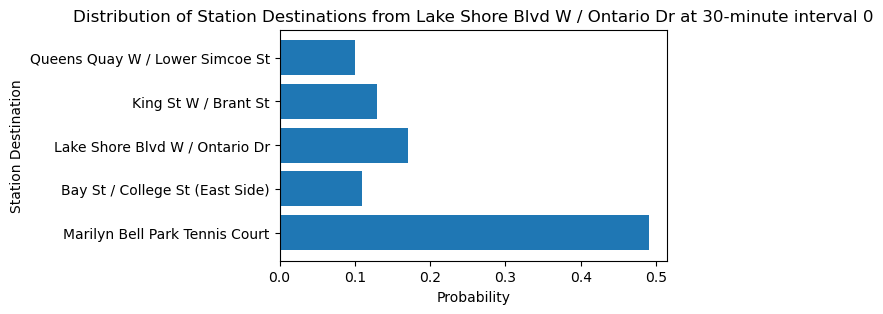

In [465]:
def ChoosingRoute(prob_df, start_station, start_time):
    try:
        start_row = prob_df.loc[(start_station, start_time)]
        probs = start_row.values
        destination = np.random.choice(start_row.index, p=probs)
        return destination
    except KeyError:
        print(
            f"No data found for start station '{start_station}' and start time '{start_time}'")


monte_carlo = []
for i in range(100):
    start_station = 'Lake Shore Blvd W / Ontario Dr'
    start_time = 0  # 30-minute interval index
    destination = ChoosingRoute(name_prob_df, start_station, start_time)
    if destination is not None:
        monte_carlo.append(destination)


prob = {}
for s in monte_carlo:
    if s in prob:
        prob[s] += 1
    else:
        prob[s] = 1
for s in prob:
    prob[s] /= len(monte_carlo)

print("Real Probability")
print(name_prob_df.loc[(start_station, start_time)])
print()
print("Simulated Probability")
print(prob)
# Plot the bar chart
plt.figure(figsize=(5, 3))
plt.barh(list(prob.keys()), list(prob.values()))
plt.xlabel('Probability')
plt.ylabel('Station Destination')
plt.title(
    f'Distribution of Station Destinations from {start_station} at 30-minute interval {start_time}')
plt.show()


In [417]:
station_vs_Dest_vs_halfhour = start_end_station_prob.pivot(index=['Start Station Id', 'Start Time (per 30min)'], columns=['End Station Id'], values='Probability').fillna(0)
prob_df = station_vs_Dest_vs_halfhour.sort_values(by="Start Time (per 30min)")
prob_df.head()

,End Station Id,7000.0,7006.0,7016.0,7030.0,7033.0,7043.0,7076.0,7078.0,7168.0,7171.0,7175.0,7203.0,7217.0,7242.0,7261.0,7298.0,7322.0,7399.0,7430.0
Start Station Id,Start Time (per 30min),,,,,,,,,,,,,,,,,,,
7000,0.0,0.000,0.000,0.0,0.0,1.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.000,0.0,0.000000,0.0
7006,0.0,0.125,0.125,0.0,0.0,0.25,0.0,0.000000,0.0,0.125000,0.0,0.0,0.0,0.25,0.0,0.000000,0.125,0.0,0.000000,0.0
7399,0.0,0.000,0.000,0.0,0.0,0.00,0.2,0.200000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.200000,0.000,0.0,0.400000,0.0
7033,0.0,0.000,0.000,0.0,0.5,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.500000,0.000,0.0,0.000000,0.0
7261,0.0,0.000,0.000,0.0,0.0,0.00,0.0,0.166667,0.0,0.333333,0.0,0.0,0.0,0.00,0.0,0.333333,0.000,0.0,0.166667,0.0


## Trip Durations

### Different Stations Destinations

In [418]:
with open('top20_diff_google_bike_trip_est.pickle', 'rb') as f:
    google_bike_trip = pickle.load(f)

diff_stations_subset_df = pd.read_csv("diff_stations_subset_df.csv")
google = pd.DataFrame((np.array(google_bike_trip)), columns=["Google"])
observed = pd.DataFrame(np.array((diff_stations_subset_df["Trip_Duration"].values)), columns=["Observed"])
trip_reg_df = pd.DataFrame({"Observed": np.array((diff_stations_subset_df["Trip_Duration"].values)*60), "Google": np.array(google_bike_trip)})
trip_reg_df.head()


,Observed,Google
0,1774.0,582
1,1761.0,582
2,1098.0,582
3,892.0,582
4,1310.0,582


In [419]:
trip_reg_df.describe()


,Observed,Google
count,16202.000000,16202.000000
mean,892.046599,455.499198
std,459.080990,274.908215
min,64.000000,34.000000
25%,504.000000,249.000000
50%,841.500000,421.000000
75%,1246.000000,644.000000
max,1980.000000,1521.000000


Error Mean -1.5261626468615904e-16
Residual Variance: 0.25580459588191384

Beta: 0.4513542745881248
Intercept: 3.974270551809947
R^2: 0.3143043103068821


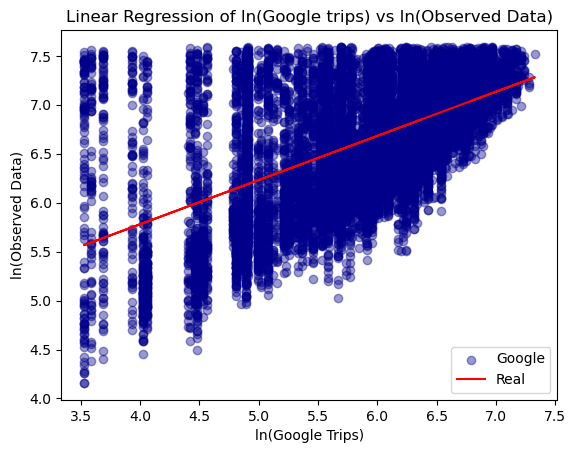

In [420]:
np.random.seed(1)

X = np.log(trip_reg_df["Google"].values)
y = np.log(trip_reg_df["Observed"].values)

X = np.array(X).reshape(-1, 1)

# set regression through the origin
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
predictions = model.predict(X)
score = model.score(X, y)
beta = model.coef_[0]
intercept = model.intercept_

residuals = y - predictions
residual_var = np.var(residuals)
residual_mean = np.mean(residuals)

print("Error Mean", residual_mean)
print("Residual Variance:", residual_var)
print()
print('Beta:', beta)
print('Intercept:', intercept)
print("R^2:", score)

plt.scatter(X, y, color='darkblue', alpha=0.4)
plt.plot(X, predictions, color='red')
plt.title("Linear Regression of ln(Google trips) vs ln(Observed Data)")
plt.ylabel("ln(Observed Data)")
plt.xlabel("ln(Google Trips)")
plt.legend(["Google", "Real"], loc="lower right")
plt.show()


Pre Residual Mean -1.5261626468615904e-16
Pre Residual Variance: 0.25580459588191384

New Resiudal Mean -5.530146832449613e-16
New Residual Variance: 0.12858666740184382

Beta: 0.47504569391691565
Intercept: 3.8372405086866
R^2: 0.6553176721259963


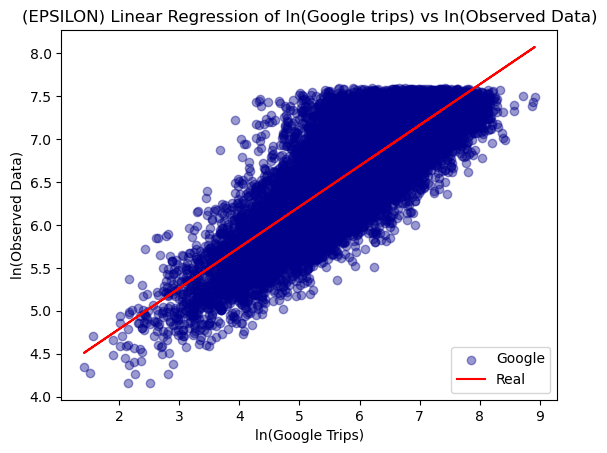

In [421]:
np.random.seed(1)

X = np.log(trip_reg_df["Google"].values)
y = np.log(trip_reg_df["Observed"].values)

X_i = np.array(X).reshape(-1, 1)

# set regression through the origin
model = LinearRegression(fit_intercept=True)
model.fit(X_i, y)
predictions = model.predict(X_i)
score = model.score(X_i, y)
beta = model.coef_[0]
intercept = model.intercept_

residuals = y - predictions
residual_mean = np.mean(residuals)
residual_var = np.var(residuals)
residual_std = np.std(residuals)

error_sd = np.sqrt(residual_var)
errors = np.random.normal(
    loc=residual_mean, scale=residual_std, size=len(residuals))
epsilon = residuals - errors

new_X = X + epsilon
new_X_i = np.array(new_X).reshape(-1, 1)

# Fit linear regression model
model = LinearRegression(fit_intercept=True)
model.fit(new_X_i, y)
new_predictions = model.predict(new_X_i)

# Calculate R-squared and print results
r2 = model.score(new_X_i, y)
new_beta = model.coef_[0]
new_intercept = model.intercept_

new_residuals = y - new_predictions
new_residual_mean = np.mean(new_residuals)
new_residual_var = np.var(new_residuals)
new_residual_std = np.std(new_residuals)
print("Pre Residual Mean", residual_mean)
print("Pre Residual Variance:", residual_var)
print()

print("New Resiudal Mean", new_residual_mean)
print("New Residual Variance:", new_residual_var)
print()
print('Beta:', new_beta)
print('Intercept:', new_intercept)
print("R^2:", r2)

plt.scatter(new_X_i, y, color='darkblue', alpha=0.4)
plt.plot(new_X_i, new_predictions, color='red')
plt.title("(EPSILON) Linear Regression of ln(Google trips) vs ln(Observed Data)")
plt.ylabel("ln(Observed Data)")
plt.xlabel("ln(Google Trips)")
plt.legend(["Google", "Real"], loc="lower right")
plt.show()


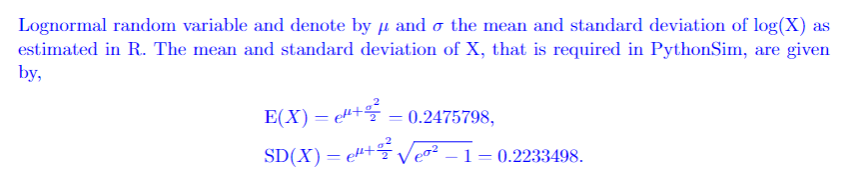

In [422]:
global E_x, SD_X

u = residual_mean
std = np.sqrt(residual_var)
E_x = np.exp(u + ((std**2)/2))
SD_x = np.exp(u + ((std**2)/2)) * np.sqrt(np.exp(std**2) - 1)
print(E_x, SD_x)


1.1364419645529011 0.6135737822915353


### Same Start and End Destination

In [423]:
same_stations_subset_df = pd.read_csv("same_stations_subset_df.csv")
same_stations_subset_df

,Unnamed: 0,index,Trip Id,Trip_Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,NumOfTrips
0,0,88,17515597,1.250000,7261,08/01/2022 00:12,Queens Quay E / Lower Sherbourne St,7261.0,08/01/2022 00:13,Queens Quay E / Lower Sherbourne St,1815,Casual Member,156
1,1,90,17520082,20.633333,7261,08/01/2022 10:37,Queens Quay E / Lower Sherbourne St,7261.0,08/01/2022 10:58,Queens Quay E / Lower Sherbourne St,5739,Annual Member,156
2,2,91,17520873,25.416667,7261,08/01/2022 11:18,Queens Quay E / Lower Sherbourne St,7261.0,08/01/2022 11:43,Queens Quay E / Lower Sherbourne St,5090,Casual Member,156
3,3,92,17527065,1.533333,7261,08/01/2022 14:46,Queens Quay E / Lower Sherbourne St,7261.0,08/01/2022 14:48,Queens Quay E / Lower Sherbourne St,2183,Casual Member,156
4,4,93,17528090,5.766667,7261,08/01/2022 15:16,Queens Quay E / Lower Sherbourne St,7261.0,08/01/2022 15:22,Queens Quay E / Lower Sherbourne St,6707,Annual Member,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2889,2889,20478,18195862,26.833333,7006,08/27/2022 13:32,Bay St / College St (East Side),7006.0,08/27/2022 13:58,Bay St / College St (East Side),4243,Casual Member,46
2890,2890,20479,18214675,32.016667,7006,08/27/2022 21:53,Bay St / College St (East Side),7006.0,08/27/2022 22:25,Bay St / College St (East Side),295,Casual Member,46
2891,2891,20481,18277866,25.800000,7006,08/30/2022 16:13,Bay St / College St (East Side),7006.0,08/30/2022 16:39,Bay St / College St (East Side),4007,Casual Member,46
2892,2892,20482,18289543,1.016667,7006,08/30/2022 23:16,Bay St / College St (East Side),7006.0,08/30/2022 23:17,Bay St / College St (East Side),5573,Casual Member,46


### Average Trip Durations between Specific Stations

In [424]:
# Convert the start time and end time to minutes
subset_df['Start Time'] = pd.to_datetime(subset_df['Start Time'])
subset_df['End Time'] = pd.to_datetime(subset_df['End Time'])
subset_df['Start Time (per 30min)'] = (subset_df['Start Time'].dt.hour * 60 + (subset_df['Start Time'].dt.minute // 30) * 30 ) / 30
subset_df['End Time (per 30min)'] = (subset_df['End Time'].dt.hour * 60 + (subset_df['End Time'].dt.minute // 30) * 30 ) / 30

# Group the data by start and end station and 30-minute interval, and calculate the average trip duration in seconds for each group
Station_HalfHour_AvgDuration = subset_df.groupby([subset_df['Start Station Name'], subset_df['Start Station Id'], subset_df['End Station Name'], subset_df['End Station Id'], subset_df['Start Time (per 30min)']])['Trip_Duration'].mean().reset_index(name='Avg_Trip_Duration')

Station_HalfHour_AvgDuration['Avg_Trip_Duration'] = Station_HalfHour_AvgDuration['Avg_Trip_Duration']

# Display the result
avg_trip_duration = Station_HalfHour_AvgDuration.sort_values(by="Start Time (per 30min)")
avg_trip_duration


,Start Station Name,Start Station Id,End Station Name,End Station Id,Start Time (per 30min),Avg_Trip_Duration
0,Bathurst St / Adelaide St W,7298,Bathurst St / Adelaide St W,7298.0,0.0,5.691667
4287,Queens Quay / Yonge St,7168,Queens Quay / Yonge St,7168.0,0.0,25.391667
4211,Queens Quay / Yonge St,7168,Lower Jarvis / Queens Quay E,7399.0,0.0,2.950000
758,Bay St / College St (East Side),7006,Fort York Blvd / Capreol Ct,7000.0,0.0,17.850000
4068,Queens Quay / Yonge St,7168,Bathurst St/Queens Quay(Billy Bishop Airport),7203.0,0.0,10.508333
...,...,...,...,...,...,...
1284,Bay St / Wellesley St W,7030,Bathurst St/Queens Quay(Billy Bishop Airport),7203.0,47.0,23.950000
5379,Union Station,7033,Bathurst St/Queens Quay(Billy Bishop Airport),7203.0,47.0,20.500000
2572,King St W / Brant St,7322,Lower Jarvis / Queens Quay E,7399.0,47.0,26.200000
2743,Lake Shore Blvd W / Ontario Dr,7242,Bay St / College St (East Side),7006.0,47.0,22.466667


In [425]:
avg_trip_duration["Avg_Trip_Duration"].describe()


count    6124.000000
mean       14.446534
std         6.952742
min         1.016667
25%         8.966667
50%        14.012500
75%        19.360417
max        33.000000
Name: Avg_Trip_Duration, dtype: float64

# Classes & Functions

## Classes

- Decide on the time units
    - Min 

In [487]:
class Station:
    def __init__(self, station_id, level, capacity):
        self.id = station_id
        self.level = level
        self.capacity = capacity
        self.bikes = {}
        self.bike_list = []
        for i in range(level):
            bike_id = f"{station_id}-{i+1}"  # create unique bike ID
            self.bikes[bike_id] = True  # mark bike as available
            self.bike_list.append(bike_id)

    def rent_bike(self):
        # Request a bike from the station
        if self.level > 0:
            if self.bike_list:
                random_index = np.random.randint(0, len(self.bike_list))
                bike_id = self.bike_list.pop(random_index)
                self.level -= 1
                return bike_id
        return None

    def return_bike(self, bike_id):
        # # Return a bike to the station
        if self.level < self.capacity:
            self.bike_list.append(bike_id)
            self.level += 1

    def Get_Bike_List(self):
        return self.bike_list


class Customer:
    def __init__(self, customer_id, start_s_id, bike=None):
        self.customer_id = customer_id
        self.start_s_id = start_s_id
        self.end_s_id = 0
        self.station_level = 0
        self.bike = bike
        self.T = None
        self.Min = None

    def rent_bike(self):
        station = StationDict[self.start_s_id]
        print(f"Customer Arrives at S{station.id} with Level: {station.level}")

        if station.level > 0:
            self.bike = station.rent_bike()
            self.station_level = station.level
            print(f"    [Customer Rent Bikes] Customer ID: {self.customer_id} | Bike ID {self.bike} || Start Time: {self.T}:{self.Min} || From: S{self.start_s_id} -> Remaining Level: {self.station_level}")
            self.Departure()
        else:
            print(f"    -   (EMPTY) -- Customer {self.customer_id} CANNOT RENT BIKE -- EMPTY STATION {self.start_s_id} w/ level {self.station_level} -- (EMPTY)")

    # def return_bike(self, end_station, bike):
    #     destination_station = StationDict[end_station]
    #     destination_station.return_bike(bike)
    #     self.station_level = destination_station.level
        
    def return_bike(self, end_station, bike):
        destination_station = StationDict[end_station]

        if destination_station.level >= destination_station.capacity:
            print(f"    -   (FULL) Customer {self.customer_id} CANNOT RETURN BIKE -- FULL STATION {destination_station.id} w/ level {destination_station.level} -- (FULL)")

        else:
            destination_station.return_bike(bike)
            self.station_level = destination_station.level
        
    
    def Departure(self):
        self.end_s_id = int(self.Destination(retrial=0))
        SimFunctions.Schedule(Calendar, "Bike_Arrival", min(8, self.TripDuration()))
        return self.end_s_id
    

######
#HELPER FUNCTIONS
######
    def Destination(self, retrial=0):
        end_s_id = None
        while end_s_id is None:
            end_s_id = self.ChoosingRoute(prob_df, start_s_id=self.start_s_id, start_time=self.T)
        end_station = StationDict[end_s_id]

        if self.bike is None:
            print(f"    -   Customer ID: {self.customer_id} Leaves from empty | From: {self.start_s_id} -> Remaining Level {self.station_level}")
        elif retrial == 1:
            pass

        elif retrial == 0 and self.bike is not None:
            print(f"        [DEPARTING] Customer ID: {self.customer_id} | Bike ID: {self.bike} || Start T:{self.T}:{self.Min} || From: S{self.start_s_id} -> Level {self.station_level} | To: S{end_station.id} -> Level {end_station.level}")
        return end_s_id
    
    def ChoosingRoute(self, prob_df, start_s_id, start_time):
        retry = None
        try:
            #np.random.seed(2)
            start_row = prob_df.loc[(start_s_id, start_time)]
            probs = start_row.values
            end_s_id = np.random.choice(start_row.index, p=probs)
            return end_s_id
        except KeyError:
            print(f"No data found for start station '{start_s_id}' and start time '{start_time}'")
            retry = None
            return retry

    def TripDuration(self):
        #print(f"Customer ID = {self.customer_id} | T={self.T} | start_id = {self.start_s_id} | end_id = {self.end_s_id}")
        duration_data = avg_trip_duration[(avg_trip_duration["Start Time (per 30min)"] == self.T) &
                                          (avg_trip_duration["Start Station Id"] == self.start_s_id) &
                                          (avg_trip_duration["End Station Id"] == self.end_s_id)]["Avg_Trip_Duration"].values[0]
        trip_time = duration_data * SimRNG_Modified.Lognormal(ZSimRNG, E_x, SD_x**2, 4)
        trip_time = min(30, np.round(trip_time))
        trip_time = max(2, trip_time)
        print(f"            [Expected Trip Time] {trip_time} | Start T: {self.T}:{self.Min} || start_id: S{self.start_s_id} | end_id: S{self.end_s_id}")

        return trip_time


## Functions

In [488]:
def Start():
    SimFunctions.Schedule(Calendar, "Customer_Arrival", SimRNG_Modified.Expon(ZSimRNG, 0, 1))
    
def NextCustomerID():
    if not hasattr(NextCustomerID, "counter"):
        NextCustomerID.counter = 0
    NextCustomerID.counter += 1
    return NextCustomerID.counter

## Trip Process Functions

In [489]:
def Customer_Arrival_Rate(T):
    #np.random.seed(1)
    temp_df = arrival_df[arrival_df["Start Time (per 30min)"] == T]
    arrival_rates = temp_df["ArrivalRate (per min)"].values
    possible_station_ids = temp_df["Start Station Id"].values
    selected_station_id = np.random.choice(possible_station_ids, p=(arrival_rates / arrival_rates.sum()))
    arrival_rate = arrival_df[(arrival_df["Start Time (per 30min)"] == T) & (arrival_df["Start Station Id"] == selected_station_id)]["ArrivalRate (per min)"].values[0]
    return arrival_rate, selected_station_id

def Customer_Arrival(empty_error, CustomerList, T, Min):
    arrival_rate, station_id = Customer_Arrival_Rate(T)
    mu = 1/arrival_rate
    SimFunctions.Schedule(Calendar, "Customer_Arrival", min(30, np.round(SimRNG_Modified.Expon(ZSimRNG, mu, 1))))
    
    station = StationDict[station_id]
    customer_id = NextCustomerID()
    customer = Customer(customer_id, station_id)
    customer.start_s_id = station_id
    customer.station_level = station.level
    customer.T = T
    customer.Min = Min
################################################################
# STATION EMPTY
################################################################
    if customer.station_level == 0:
        print(f"    (EMPTY) -- Customer {customer.customer_id} CANNOT RENT BIKE | S{customer.start_s_id} -> level {customer.station_level} -- (EMPTY)")
        empty_error += 1
    else:
        CustomerList.append(customer)
        customer.rent_bike()
        
    return empty_error, customer


def Bike_Arrival(Full_Error, CustomerList, temp_customer, T, Min):
    end_s_id = temp_customer.end_s_id
    if end_s_id != 0:
        end_station = StationDict[end_s_id] 
        
        if end_station.level < end_station.capacity:
            for customer in CustomerList:
                if customer.end_s_id == end_station.id and customer.bike is not None:
                    customer.return_bike(customer.end_s_id, customer.bike)
                    print(f"                [BIKE RETURNED] Customer ID: {customer.customer_id} | Bike ID: {customer.bike} || Start T:{customer.T}:{customer.Min} - End T:{T}:{Min} || To: S{end_station.id} -> Level {end_station.level} | From: S{customer.start_s_id} ")                                                                                          
                    CustomerList.remove(customer)
                    return Full_Error

    ################################################################
    #STATION FULL
    ################################################################
        else:
            for customer in CustomerList:
                customer_end_station = StationDict[customer.start_s_id]
                if customer.end_s_id == customer_end_station.id and customer_end_station.level >= customer_end_station.capacity:
                    temp_customer = customer
                    print(f"     (FULL) -- Start T:{customer.T}:{customer.Min} - End T:{T}:{Min} || Customer ID: {customer.customer_id} || To: S{end_station.id} -> Level {end_station.level} | Capacity {end_station.capacity} || From: S{customer.start_s_id} -- (FULL)")
                    Full_Error += 1
                    SimFunctions.Schedule(Calendar, "Retrial", 0.1) # Schedule Retrial instantly
                    Retrial(Full_Error, CustomerList,temp_customer=temp_customer, T=T, Min=Min)
                    return Full_Error
                else:
                    pass
    else:
        pass
    
    return Full_Error


def Retrial(Full_Error, temp_customer, T, Min):
    customer = temp_customer
    customer.T = T
    customer.Min = Min
    customer.end_s_id = customer.Destination(retrial=1)
    print(f"    [NEW STATION] T:{customer.T}:{customer.Min} Customer ID: {customer.customer_id} tries new station S{customer.end_s_id}")
    trip_time = customer.TripDuration()
    SimFunctions.Schedule(Calendar, "Bike_Arrival", min(30, trip_time))

    return Full_Error


# Simulation

In [490]:
NextCustomerID.counter = 0

ZSimRNG = SimRNG_Modified.InitializeRNSeed()

Calendar = SimClasses.EventCalendar()

Queue = SimClasses.FIFOQueue()
Wait = SimClasses.DTStat()
Bikes = SimClasses.Resource()

TheCTStats = []
TheDTStats = []
TheQueues = []
TheResources = []

CustomerList = []
Full_Error_list = []
Empty_Error_list = []

MeanTBA = 0.5
MeanTR = 0.5
MeanST = 0.5

Phases = 3
RunLength = 50
WarmUp = 5
end_s_id = 1


for days in range(0, 1, 1):
    Full_Error = 0
    Empty_Error = 0
    Stations = []

    # Initialize the stations and create a dictionary mapping station IDs to Station instances
    unique_stations = np.unique(subset_df["Start Station Id"].values)
    for station in unique_stations:
        r_i = np.random.randint(4, 5)
        x_i = np.random.randint(3, r_i)
        Stations.append(Station(station_id=station, level=x_i, capacity=r_i))
    

    StationDict = {station.id: station for station in Stations}
    for station_id, station in StationDict.items():
        print(f"Station {station_id} Inital Bike List: {station.Get_Bike_List()}")
        
    SimFunctions.SimFunctionsInit(Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
    SimFunctions.Schedule(Calendar, "Start", SimRNG_Modified.Expon(ZSimRNG, 0, 1))
        
    NextEvent = Calendar.Remove()
    SimClasses.Clock = NextEvent.EventTime
    if NextEvent.EventType == "Start":
        Start()

    for T in [i for i in range(8,24)]:  # T = hours intervals
        print(f"30 Min Interval T = {T}")
        for minutes in [i for i in range(1, 31)]:  # 30 min intervals
            print("Minute = {}".format(minutes))
            
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            
            #print(Calendar.N())
            if NextEvent.EventType == "Customer_Arrival":
                Empty_Error, customer = Customer_Arrival(Empty_Error, CustomerList, T, minutes)
            
            elif NextEvent.EventType == "Bike_Arrival":
                Full_Error = Bike_Arrival(Full_Error, CustomerList, customer, T, minutes)
            
            elif NextEvent.EventType == "Retrial":
                Full_Error = Retrial(Full_Error, CustomerList, customer, T, minutes)
               
    for station_id, station in StationDict.items():
        print(f"Station {station_id} Bike List: {station.Get_Bike_List()}")

    print(f"Num of Full Errors: {Full_Error}")
    print(f"Num of Empty Errors: {Empty_Error}")
    Full_Error_list.append(Full_Error)
    Empty_Error_list.append(Empty_Error)
    print(f"End of Day {days}")
    print("--------------------------------------------------------------------------------------------------------------------------------------------------")


Station 7000 Inital Bike List: ['7000-1', '7000-2', '7000-3']
Station 7006 Inital Bike List: ['7006-1', '7006-2', '7006-3']
Station 7016 Inital Bike List: ['7016-1', '7016-2', '7016-3']
Station 7030 Inital Bike List: ['7030-1', '7030-2', '7030-3']
Station 7033 Inital Bike List: ['7033-1', '7033-2', '7033-3']
Station 7043 Inital Bike List: ['7043-1', '7043-2', '7043-3']
Station 7076 Inital Bike List: ['7076-1', '7076-2', '7076-3']
Station 7078 Inital Bike List: ['7078-1', '7078-2', '7078-3']
Station 7168 Inital Bike List: ['7168-1', '7168-2', '7168-3']
Station 7171 Inital Bike List: ['7171-1', '7171-2', '7171-3']
Station 7175 Inital Bike List: ['7175-1', '7175-2', '7175-3']
Station 7203 Inital Bike List: ['7203-1', '7203-2', '7203-3']
Station 7217 Inital Bike List: ['7217-1', '7217-2', '7217-3']
Station 7242 Inital Bike List: ['7242-1', '7242-2', '7242-3']
Station 7261 Inital Bike List: ['7261-1', '7261-2', '7261-3']
Station 7298 Inital Bike List: ['7298-1', '7298-2', '7298-3']
Station 

In [491]:
for station_id, station in StationDict.items():
    print(f"Station {station_id} Bike List: {station.Get_Bike_List()}")
    print(station.level)
    print(station.capacity)
print(f"Num of Full Errors: {Full_Error}")
print(f"Num of Empty Errors: {Empty_Error}")


Station 7000 Bike List: []
0
4
Station 7006 Bike List: ['7217-1']
1
4
Station 7016 Bike List: []
0
4
Station 7030 Bike List: []
0
4
Station 7033 Bike List: []
0
4
Station 7043 Bike List: []
0
4
Station 7076 Bike List: []
0
4
Station 7078 Bike List: []
0
4
Station 7168 Bike List: []
0
4
Station 7171 Bike List: []
0
4
Station 7175 Bike List: []
0
4
Station 7203 Bike List: []
0
4
Station 7217 Bike List: []
0
4
Station 7242 Bike List: []
0
4
Station 7261 Bike List: []
0
4
Station 7298 Bike List: []
0
4
Station 7322 Bike List: []
0
4
Station 7399 Bike List: []
0
4
Station 7430 Bike List: []
0
4
Num of Full Errors: 1
Num of Empty Errors: 249


In [492]:
print(f"Num of Full Errors: {Full_Error_list}")
print(f"Num of Empty Errors: {Empty_Error_list}")

Num of Full Errors: [1]
Num of Empty Errors: [249]


In [493]:
# next_arrival_time = {}  # initialize empty dictionary


# def schedule_next_arrival(station_id, arrival_time):
#     # update next arrival time for the station
#     next_arrival_time[station_id] = arrival_time


# # Example usage
# station_id_1 = 1
# station_id_2 = 2

# arrival_rate_1 = 5  # hypothetical arrival rate for station 1
# arrival_rate_2 = 3  # hypothetical arrival rate for station 2

# # Schedule the first arrival for each station
# mu_1 = 1 / (30 * arrival_rate_1)  # mean inter-arrival time for station 1
# arrival_time_1 = SimRNG_Modified.Expon(ZSimRNG, mu_1, 1)[
#     0]  # generate first arrival time
# schedule_next_arrival(station_id_1, arrival_time_1)
# SimFunctions.Schedule(Calendar, "Customer_Arrival", arrival_time_1)

# mu_2 = 1 / (30 * arrival_rate_2)  # mean inter-arrival time for station 2
# arrival_time_2 = SimRNG_Modified.Expon(ZSimRNG, mu_2, 1)[
#     0]  # generate first arrival time
# schedule_next_arrival(station_id_2, arrival_time_2)
# SimFunctions.Schedule(Calendar, "Customer_Arrival", arrival_time_2)

# # At this point, the first arrivals for both stations have been scheduled. Now we can simulate the subsequent arrivals.

# while SimFunctions.NextEventTime(Calendar) < simulation_end_time:
#     current_time = SimFunctions.NextEventTime(Calendar)

#     # Find the station with the next arrival time
#     next_station_id = min(next_arrival_time, key=next_arrival_time.get)
#     next_arrival_time_for_station = next_arrival_time[next_station_id]

#     # Schedule the next arrival for the selected station
#     if next_arrival_time_for_station <= current_time:
#         schedule_next_arrival(next_station_id, current_time + SimRNG_Modified.Expon(
#             ZSimRNG, 1 / (30 * arrival_rate_for_station), 1)[0])
#         SimFunctions.Schedule(Calendar, "Customer_Arrival",
#                               next_arrival_time_for_station)

#     # Update the number of customers in the system, etc.
#     # ...
